In [1]:
import numpy as np
import h5py as h5
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn

from graph_vae import GraphVAE
from train import train_loop2
from data_load import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [3]:
dataset = get_train_dataset()
data_loader = torch.utils.data.DataLoader(dataset, 2000)

In [10]:
for (X, NL, mask) in data_loader:
    A = eval_A(NL.int())*mask.unsqueeze(2)
    print(torch.sum(A, 2))
    break

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [22]:
(A[0, :, :]*(1 - mask[0].unsqueeze(1))).max()

tensor(0.1667)

## Model Definition and training

In [3]:
net = GraphVAE(400, 3)
# net.load_state_dict(torch.load("Saves/ecal_ep_60.pth"))

<All keys matched successfully>

In [6]:
train_loop2(net, 30, 200, 1e-3, device)

Epoch : 1 Loss: 12.66592 E mse: 0.21182 Hit mse: 11.55435 L2: 2.52292
Epoch : 2 Loss: 12.57346 E mse: 0.21185 Hit mse: 11.46265 L2: 2.52320
Epoch : 3 Loss: 12.58838 E mse: 0.21187 Hit mse: 11.47812 L2: 2.52317
Epoch : 4 Loss: 12.54606 E mse: 0.21182 Hit mse: 11.43640 L2: 2.52321
Epoch : 5 Loss: 12.55481 E mse: 0.21182 Hit mse: 11.44482 L2: 2.52306
Epoch : 6 Loss: 12.51115 E mse: 0.21181 Hit mse: 11.40123 L2: 2.52302
Epoch : 7 Loss: 12.49750 E mse: 0.21180 Hit mse: 11.38807 L2: 2.52299
Epoch : 8 Loss: 12.53382 E mse: 0.21184 Hit mse: 11.42466 L2: 2.52302
Epoch : 9 Loss: 12.47487 E mse: 0.21183 Hit mse: 11.36584 L2: 2.52294
Epoch : 10 Loss: 12.48232 E mse: 0.21184 Hit mse: 11.37372 L2: 2.52297
Epoch : 11 Loss: 12.45952 E mse: 0.21180 Hit mse: 11.35110 L2: 2.52288
Epoch : 12 Loss: 12.42640 E mse: 0.21185 Hit mse: 11.31781 L2: 2.52283
Epoch : 13 Loss: 12.44494 E mse: 0.21181 Hit mse: 11.33695 L2: 2.52289
Epoch : 14 Loss: 12.44645 E mse: 0.21182 Hit mse: 11.33947 L2: 2.52277
Epoch : 15 Loss

In [8]:
torch.save(net.state_dict(), "Saves/ecal_ep_60.pth")

tensor(0.0100)

## Inference and tests

In [9]:
def reconstruct_img3(Y, mask):
    xhit, yhit = Y[:, :, 0], Y[:, :, 1]
    val = Y[:, :, 2]/50.
    
    xhit = (xhit % 125).int()
    yhit = (yhit % 125).int()
    
    mask = mask*torch.arange(1, 0, -1./400)**2
    # mask = mask*torch.exp(-torch.arange(400))
    ecal = torch.zeros((Y.shape[0], 125, 125))
    ecal[
        torch.arange(Y.shape[0]).unsqueeze(1),
        xhit,
        yhit
    ] = mask #*val
    
    return ecal

def reconstruct_img2(Y, mask):
    xhit, yhit = (Y[:, :, 0] + 10)*6.25, (Y[:, :, 1] + 10)*6.25
    ener = ((Y[:, :, 2] + 10)/20)**10
    
    xhit = (xhit % 125).int()
    yhit = (yhit % 125).int()
    
    ecal = torch.zeros((Y.shape[0], 125, 125))
    ecal[
        torch.arange(Y.shape[0]).unsqueeze(1),
        xhit,
        yhit
    ] = mask*ener
    
    return ecal

def loss_infer2(net, X, A, mask):
    """
    Inference loss function
    """
    # Reconstructed nodes and edges
    Y, A2, mu, logvar, L1, L2 = net(X, A, mask)
    # Convert back to image
    ecal = reconstruct_img3(Y, mask)
    
    mse = torch.nn.MSELoss()
    return mse(X, Y), ecal, A2

In [5]:
net = GraphVAE(400, 3)
net.load_state_dict(torch.load("Saves/ecal_ep_60.pth"))

<All keys matched successfully>

In [10]:
dataset = get_train_dataset()
data_loader = torch.utils.data.DataLoader(dataset, 200, True)

In [11]:
for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    print(A.sum(2))
    mask = mask
    with torch.no_grad():
        img1 = reconstruct_img3(X, mask)
        L, img2, A2 = loss_infer2(net, X, A, mask)
    break

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [12]:
A.sum(2), A2.sum(2)

(tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([[251.5386, 251.5341, 251.5417,  ..., 251.5723, 251.5723, 251.5723],
         [251.5442, 251.5173, 251.5415,  ..., 251.5530, 251.5530, 251.5530],
         [251.5077, 251.5096, 251.4948,  ..., 251.5199, 251.5199, 251.5199],
         ...,
         [251.4813, 251.4783, 251.4995,  ..., 251.5530, 251.5530, 251.5530],
         [251.5406, 251.5352, 251.6220,  ..., 251.5320, 251.5320, 251.5320],
         [251.4781, 251.4804, 251.4787,  ..., 251.4909, 251.4909, 251.4909]]))

In [13]:
img1.max()

tensor(1.)

In [14]:
img2.max()

tensor(1.)

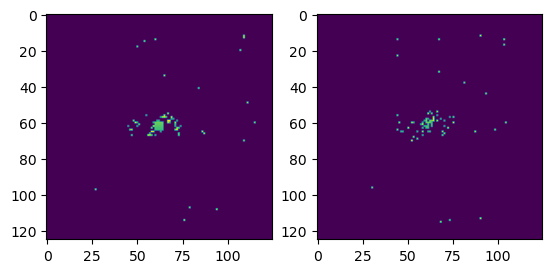

In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[1]*(256))
ax[1].imshow(img2[1]*(256))
plt.show()

## Graph dataset

In [25]:
f = h5.File("quark-gluon_data-set_n139306.hdf5")
print(f['X_jets'].shape)
f.close()

(139306, 125, 125, 3)


In [3]:
from data_load import preprocess

In [4]:
with h5.File('quark_jets_ecal.h5', 'w') as g:
    f = h5.File('quark-gluon_data-set_n139306.hdf5', 'r')
    
    dset = g.create_dataset('x', shape=(0, 125, 125, 3), dtype=np.float32,
                            maxshape=(None, 125, 125, 3))
    L = 100_000
    w = 10_000

    for i in range(10):
        x, y = f['X_jets'][i*w: (i+1)*w], f['y'][i*w: (i+1)*w]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        (ind_0,) = torch.nonzero(y==0, as_tuple=True)
        x = x[ind_0]
        curr_shape = dset.shape[0]
        dset.resize((curr_shape+x.shape[0], 125, 125, 3))
        dset[curr_shape:, :, :] = x
    print(dset.shape[0])
    f.close()

50000


This generates a 3-channel heavy-duty dataset

In [2]:
with h5.File('quark_jets_ecal.h5') as g:
    with h5.File('quark_3chan_graph.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 1000, 4), dtype=np.float32,
                            maxshape=(None, 1000, 4))
        A_dset = h.create_dataset('A', shape=(0, 1000, 1000), dtype=np.float32,
                            maxshape=(None, 1000, 1000))
        mask_dset = h.create_dataset('mask', shape=(0, 1000), dtype=np.float32,
                            maxshape=(None, 1000))
        
        device = torch.device("cpu")
        w = 2000
        for i in range(25):
            x = g['x'][i*w: (i+1)*w]
            x = torch.from_numpy(x).to(device)
            X, A, mask, _ = preprocess(x, device)
            
            curr_shape = X_dset.shape[0]
                
            X_dset.resize((curr_shape+w, 1000, 4))
            A_dset.resize((curr_shape+w, 1000, 1000))
            mask_dset.resize((curr_shape+w, 1000))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            A_dset[curr_shape:, :, :] = A.to("cpu").numpy()
            mask_dset[curr_shape:, :] = mask.to("cpu").numpy()

This generates a smaller single channel dataset

In [18]:
with h5.File('quark_jets_ecal.h5') as g:
        
    device = torch.device("cpu")
    w = 2000
    for i in range(25):
        x = g['x'][i*w: (i+1)*w]
        x[x < 1e-3] = 0
        x = torch.from_numpy(x)[:, :, :, 1].to(device)
        X, A, mask, _ = preprocess(x, device)
        
        NL = torch.argsort(A, 1, True)[:, :6, :].int()
        print((A[torch.arange(w).view(-1, 1, 1), NL, 
                torch.arange(400).view(1, 1, -1)]).sum(1))
        break

tensor([[6., 6., 6.,  ..., 0., 0., 0.],
        [6., 6., 6.,  ..., 0., 0., 0.],
        [6., 6., 6.,  ..., 0., 0., 0.],
        ...,
        [6., 6., 6.,  ..., 0., 0., 0.],
        [6., 6., 6.,  ..., 0., 0., 0.],
        [6., 6., 6.,  ..., 0., 0., 0.]])


In [21]:
with h5.File('quark_jets_ecal.h5') as g:
    with h5.File('quark_ecal_graph_compressed.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 400, 3), dtype=np.float32,
                            maxshape=(None, 400, 3), compression="gzip")
        NL_dset = h.create_dataset('NL', shape=(0, 400, 6), dtype=np.float32,
                            maxshape=(None, 400, 6), compression="gzip")
        mask_dset = h.create_dataset('mask', shape=(0, 400), dtype=np.float32,
                            maxshape=(None, 400), compression="gzip")
        
        device = "cpu"
        w = 2000
        for i in range(25):
            x = g['x'][i*w: (i+1)*w]
            x[x < 1e-3] = 0
            x = torch.from_numpy(x)[:, :, :, 1].to(device)
            X, A, mask, _ = preprocess(x, device)
            
            NL = torch.argsort(A, 1, True)[:, :6, :].int().permute(0, 2, 1)
            
            curr_shape = X_dset.shape[0]
                
            X_dset.resize((curr_shape+w, 400, 3))
            NL_dset.resize((curr_shape+w, 400, 6))
            mask_dset.resize((curr_shape+w, 400))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            NL_dset[curr_shape:, :, :] = NL.to("cpu").numpy()
            mask_dset[curr_shape:, :] = mask.int().to("cpu").numpy()
            

In [6]:
with h5.File('quark_ecal_graph.h5') as g:
    with h5.File('quark_ecal_graph_compressed.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 400, 3), dtype=np.float32,
                            maxshape=(None, 400, 3), compression="gzip")
        NL_dset = h.create_dataset('NL', shape=(0, 400, 6), dtype=np.float32,
                            maxshape=(None, 400, 6), compression="gzip")
        mask_dset = h.create_dataset('mask', shape=(0, 400), dtype=np.float32,
                            maxshape=(None, 400), compression="gzip")
        
        device = "cpu"
        w = 2000
        for i in range(25):
            X = torch.from_numpy(g['X'][i*w: (i+1)*w]).to(device)
            A = torch.from_numpy(g['A'][i*w: (i+1)*w]).to(device)
            mask = g['mask'][i*w: (i+1)*w]
            
            X[:, :, :2] = (X[:, :, :2]/62.5)
            X[:, :, 2] = (X[:, :, 2]**0.1)*2
            
            NL = torch.argsort(A, 1, True)[:, :6, :].int().permute((0, 2, 1))
            
            curr_shape = X_dset.shape[0]
                
            X_dset.resize((curr_shape+w, 400, 3))
            NL_dset.resize((curr_shape+w, 400, 6))
            mask_dset.resize((curr_shape+w, 400))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            NL_dset[curr_shape:, :, :] = NL.to("cpu").numpy()
            mask_dset[curr_shape:, :] = mask

In [2]:
dataset = get_train_dataset()